In [1]:
import geopandas as gpd
import gerrychain
import maup
import pandas
import seaborn as sns
import numpy as np

### Run a chain for County Commission district plans

In [2]:
from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges, county_splits,compactness
from gerrychain.tree import recursive_tree_part

In [3]:
data = gpd.read_file("/MAUP_YubaCounty2016.shp") #mauped shapefile here
data["geometry"] = data.buffer(0)
graph = Graph.from_geodataframe(data)
graph.add_data(data,list(data))

In [4]:
def draw_plot(data, offset, edge_color, fill_color):
    pos = 5*np.arange(data.shape[1])+1+offset
    #bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    bp = ax.boxplot(data, positions= pos,widths=.5, whis=[1,99],showfliers=False, patch_artist=True, manage_xticks=False,zorder=4)
    for element in ['boxes', 'whiskers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color,zorder=4)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,zorder=0)


In [5]:
county_name = "Yuba" #insert county name
num_districts = 5
unique_label = "GEOID10"
pop_col = "TOTPOP"

In [6]:
totpop = 0

In [7]:
for n in graph.nodes():
    #graph.node[n]["pres_clint"] = int(graph.node[n]["pres_clint"])
    #graph.node[n]["pres_trump"] = int(graph.node[n]["pres_trump"])
    graph.node[n]["TOTPOP"] = int(graph.node[n]["TOTPOP"])
    graph.node[n]["TOTVOTES"] = int(graph.node[n]['PRSDEM01']) + int(graph.node[n]["PRSGRN01"])\
        + int(graph.node[n]["PRSLIB01"]) + int(graph.node[n]["PRSPAF01"] + int(graph.node[n]["PRSREP01"]))
    if graph.node[n]["VAP"] != 0:
        graph.node[n]["TURNOUT"] = float(graph.node[n]["TOTVOTES"]) / graph.node[n]["VAP"]
    else: 
        graph.node[n]["TURNOUT"] = -1
    graph.node[n]["VAP"] = int(graph.node[n]["VAP"])
    graph.node[n]["BVAP"] = int(graph.node[n]["BVAP"])
    graph.node[n]["HVAP"] = int(graph.node[n]["HVAP"])
    graph.node[n]["WVAP"] = int(graph.node[n]["WVAP"])
    graph.node[n]["ASIANVAP"] = int(graph.node[n]["ASIANVAP"])
    graph.node[n]["WVAP"] = int(graph.node[n]["WVAP"])
    graph.node[n]["nASIANVAP"] =  graph.node[n]["VAP"] - graph.node[n]["ASIANVAP"]
    graph.node[n]["nBVAP"] =  graph.node[n]["VAP"] - graph.node[n]["BVAP"]
    graph.node[n]["nHVAP"] =  graph.node[n]["VAP"] - graph.node[n]["HVAP"]
    graph.node[n]["nWVAP"] =  graph.node[n]["VAP"] - graph.node[n]["WVAP"]
    if graph.node[n]["VAP"]!= 0:
        graph.node[n]["TURNOUT"] =  graph.node[n]["TOTVOTES"]/graph.node[n]["VAP"]
    else: 
        graph.node[n]["TURNOUT"] = -1
    totpop +=graph.node[n]["TOTPOP"]
    

In [8]:
updater = {
        "population": updaters.Tally("TOTPOP", alias="population"),
    "TOTVOTES": updaters.Tally("TOTVOTES", alias="TOTVOTES"),
    "VAP": updaters.Tally("VAP", alias="VAP"),
    "cut_edges": cut_edges,
    "BVAP":Election("BVAP",{"BVAP":"BVAP","nBVAP":"nBVAP"}),
    "HVAP":Election("HVAP",{"HVAP":"HVAP","nHVAP":"nHVAP"}),
    "WVAP":Election("WVAP",{"WVAP":"WVAP","nWVAP":"nWVAP"}),
    "ASIANVAP":Election("ASIANVAP",{"ASIANVAP":"ASIANVAP","nASIANVAP":"nASIANVAP"}),
    # CHECK: These should be county-specific
    #
    
    "2016_pres" : Election("2016_pres", {"PRSDEM01":"PRSDEM01" , "PRSGRN01":"PRSGRN01", 
                                "PRSLIB01":"PRSLIB01", "PRSPAF01":"PRSPAF01", "PRSREP01":"PRSREP01"}),
    "2016_cong" : Election("2016_cong", {"CNGDEM01":"CNGDEM01" , "CNGREP01":"CNGREP01"}),
    "2016_ussn" : Election("2016_ussn", {"USSDEM01":"USSDEM01" , "USSDEM02":"USSDEM02"})
}



Check that total population seems consistent with Census Bureau data

In [9]:
totpop

72135

##  Let's chain

In [10]:
from gerrychain.tree import bipartition_tree

def recursive_tree_part(
    graph, parts, pop_target, pop_col, epsilon, node_repeats=1, method=bipartition_tree
):
    """Uses :func:`~gerrychain.tree_methods.bipartition_tree` recursively to partition a tree into
    ``len(parts)`` parts of population ``pop_target`` (within ``epsilon``). Can be used to
    generate initial seed plans or to implement ReCom-like "merge walk" proposals.

    :param graph: The graph
    :param parts: Iterable of part labels (like ``[0,1,2]`` or ``range(4)``
    :param pop_target: Target population for each part of the partition
    :param pop_col: Node attribute key holding population data
    :param epsilon: How far (as a percentage of ``pop_target``) from ``pop_target`` the parts
        of the partition can be
    :param node_repeats: Parameter for :func:`~gerrychain.tree_methods.bipartition_tree` to use.
    :return: New assignments for the nodes of ``graph``.
    :rtype: dict
    """
    flips = {}
    remaining_nodes = set(graph.nodes)
    # We keep a running tally of deviation from ``epsilon`` at each partition
    # and use it to tighten the population constraints on a per-partition
    # basis such that every partition, including the last partition, has a
    # population within +/-``epsilon`` of the target population.
    # For instance, if district n's population exceeds the target by 2%
    # with a +/-2% epsilon, then district n+1's population should be between
    # 98% of the target population and the target population.
    debt = 0

    for part in parts[:-1]:
        min_pop = max(pop_target * (1 - epsilon), pop_target * (1 - epsilon) - debt)
        max_pop = min(pop_target * (1 + epsilon), pop_target * (1 + epsilon) - debt)
        nodes = method(
            graph.subgraph(remaining_nodes),
            pop_col=pop_col,
            pop_target=(min_pop + max_pop) / 2,
            epsilon=(max_pop - min_pop) / (2 * pop_target),
            node_repeats=node_repeats,
        )

        part_pop = 0
        for node in nodes:
            flips[node] = part
            part_pop += graph.nodes[node][pop_col]
        debt += part_pop - pop_target
        remaining_nodes -= nodes

    # All of the remaining nodes go in the last part
    for node in remaining_nodes:
        flips[node] = parts[-1]

    return flips


In [11]:
start = recursive_tree_part(graph,range(num_districts),round(totpop/num_districts),"TOTPOP", .02,1)

In [12]:
initial_partition =Partition(graph,start, updater)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

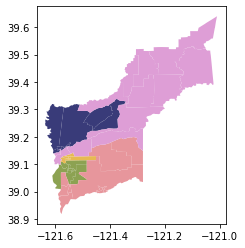

In [14]:
initial_partition.plot(data, cmap = 'tab20b')

In [15]:
from functools import partial

In [16]:
proposal = partial(
        recom, pop_col="TOTPOP", pop_target=totpop/num_districts, epsilon=0.05, node_repeats=1)
compactness_bound =constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2* len(initial_partition["cut_edges"] ))
    
MC = MarkovChain(
    proposal=proposal,
    constraints=[
    constraints.within_percent_of_ideal_population(initial_partition, 0.05),compactness_bound
     # constraints.single_flip_contiguous#no_more_discontiguous
    ],
    accept = accept.always_accept,
    initial_state=initial_partition,
    total_steps=10000
)


In [17]:
from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini

chain <Partition [5 parts]> step 100
chain <Partition [5 parts]> step 200
chain <Partition [5 parts]> step 300
chain <Partition [5 parts]> step 400
chain <Partition [5 parts]> step 500
chain <Partition [5 parts]> step 600
chain <Partition [5 parts]> step 700
chain <Partition [5 parts]> step 800
chain <Partition [5 parts]> step 900
chain <Partition [5 parts]> step 1000
chain <Partition [5 parts]> step 1100


/anaconda3/envs/vrdi/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/anaconda3/envs/vrdi/lib/python3.7/site-packages/geopandas/plotting.py:413: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


chain <Partition [5 parts]> step 1200
chain <Partition [5 parts]> step 1300
chain <Partition [5 parts]> step 1400
chain <Partition [5 parts]> step 1500
chain <Partition [5 parts]> step 1600
chain <Partition [5 parts]> step 1700
chain <Partition [5 parts]> step 1800
chain <Partition [5 parts]> step 1900
chain <Partition [5 parts]> step 2000
chain <Partition [5 parts]> step 2100
chain <Partition [5 parts]> step 2200
chain <Partition [5 parts]> step 2300
chain <Partition [5 parts]> step 2400
chain <Partition [5 parts]> step 2500
chain <Partition [5 parts]> step 2600
chain <Partition [5 parts]> step 2700
chain <Partition [5 parts]> step 2800
chain <Partition [5 parts]> step 2900
chain <Partition [5 parts]> step 3000
chain <Partition [5 parts]> step 3100
chain <Partition [5 parts]> step 3200
chain <Partition [5 parts]> step 3300
chain <Partition [5 parts]> step 3400
chain <Partition [5 parts]> step 3500
chain <Partition [5 parts]> step 3600
chain <Partition [5 parts]> step 3700
chain <Parti

<Figure size 432x288 with 0 Axes>

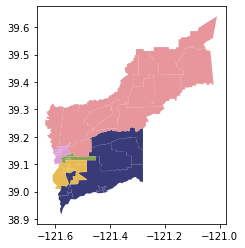

<Figure size 432x288 with 0 Axes>

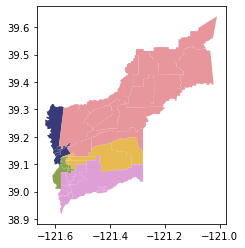

<Figure size 432x288 with 0 Axes>

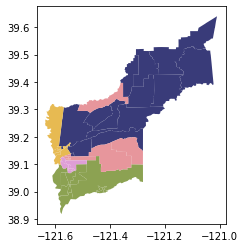

<Figure size 432x288 with 0 Axes>

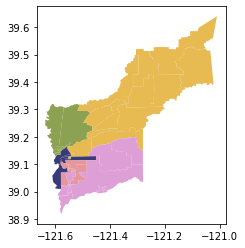

<Figure size 432x288 with 0 Axes>

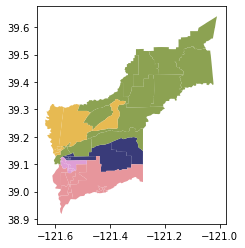

<Figure size 432x288 with 0 Axes>

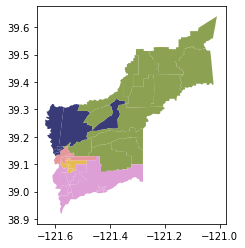

<Figure size 432x288 with 0 Axes>

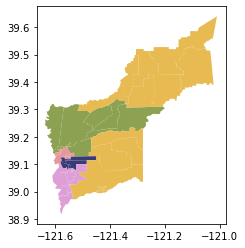

<Figure size 432x288 with 0 Axes>

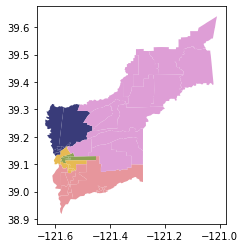

<Figure size 432x288 with 0 Axes>

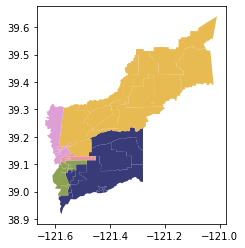

<Figure size 432x288 with 0 Axes>

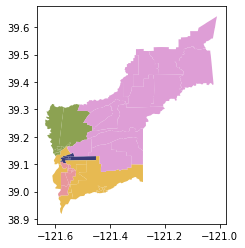

<Figure size 432x288 with 0 Axes>

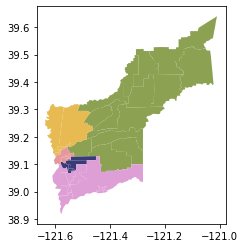

<Figure size 432x288 with 0 Axes>

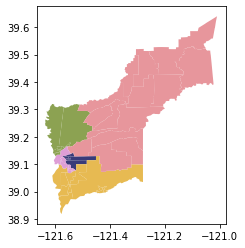

<Figure size 432x288 with 0 Axes>

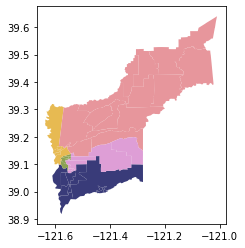

<Figure size 432x288 with 0 Axes>

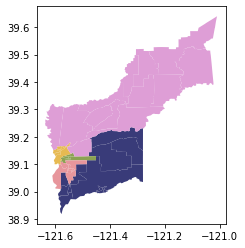

<Figure size 432x288 with 0 Axes>

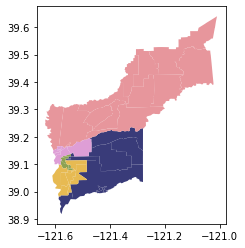

<Figure size 432x288 with 0 Axes>

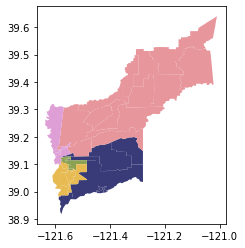

<Figure size 432x288 with 0 Axes>

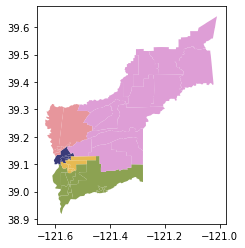

<Figure size 432x288 with 0 Axes>

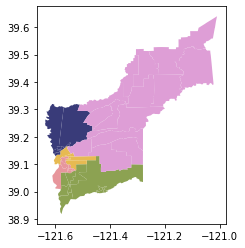

<Figure size 432x288 with 0 Axes>

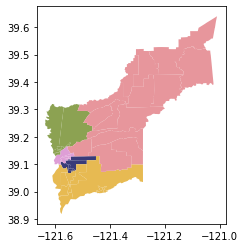

<Figure size 432x288 with 0 Axes>

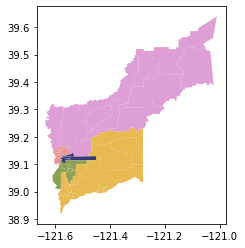

<Figure size 432x288 with 0 Axes>

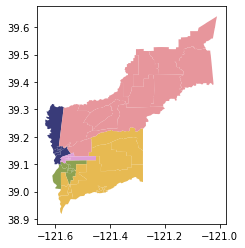

<Figure size 432x288 with 0 Axes>

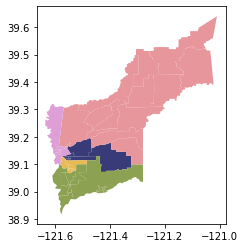

<Figure size 432x288 with 0 Axes>

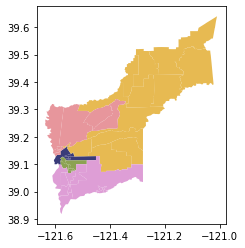

<Figure size 432x288 with 0 Axes>

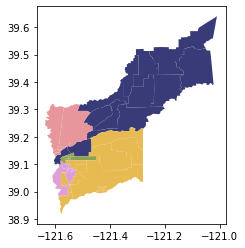

<Figure size 432x288 with 0 Axes>

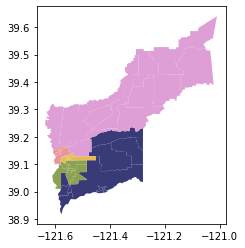

<Figure size 432x288 with 0 Axes>

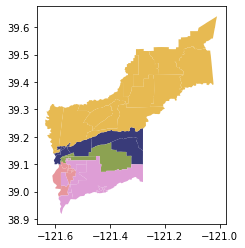

<Figure size 432x288 with 0 Axes>

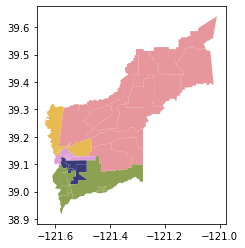

<Figure size 432x288 with 0 Axes>

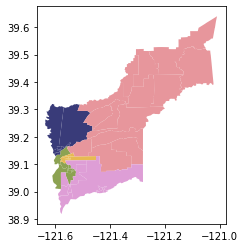

<Figure size 432x288 with 0 Axes>

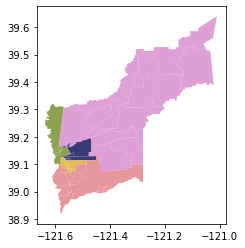

<Figure size 432x288 with 0 Axes>

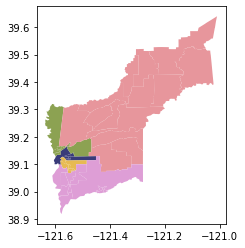

<Figure size 432x288 with 0 Axes>

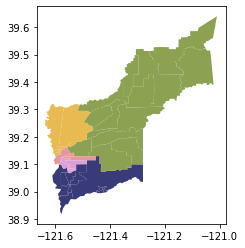

<Figure size 432x288 with 0 Axes>

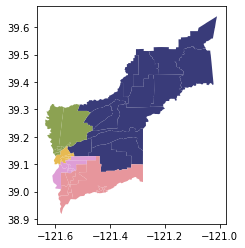

<Figure size 432x288 with 0 Axes>

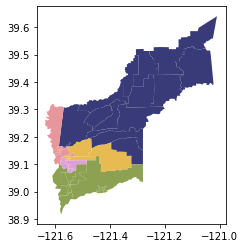

<Figure size 432x288 with 0 Axes>

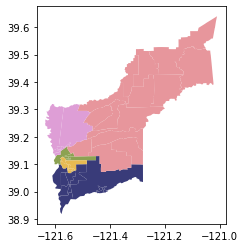

<Figure size 432x288 with 0 Axes>

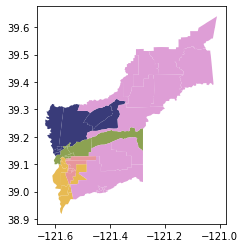

<Figure size 432x288 with 0 Axes>

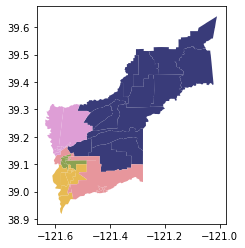

<Figure size 432x288 with 0 Axes>

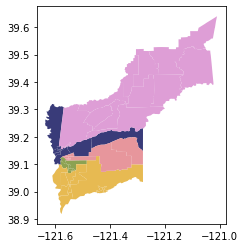

<Figure size 432x288 with 0 Axes>

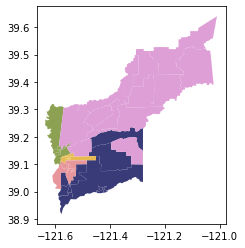

<Figure size 432x288 with 0 Axes>

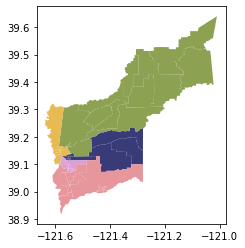

<Figure size 432x288 with 0 Axes>

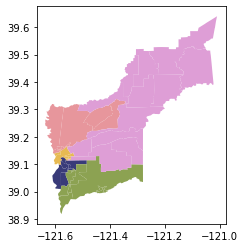

<Figure size 432x288 with 0 Axes>

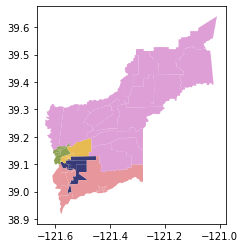

<Figure size 432x288 with 0 Axes>

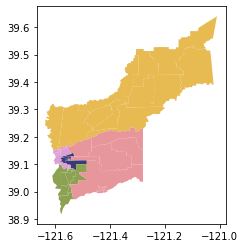

<Figure size 432x288 with 0 Axes>

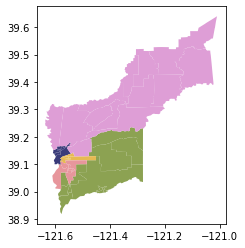

<Figure size 432x288 with 0 Axes>

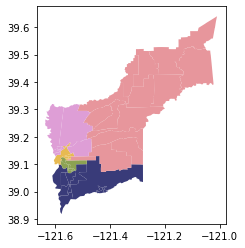

<Figure size 432x288 with 0 Axes>

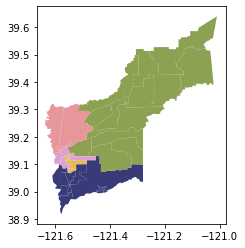

<Figure size 432x288 with 0 Axes>

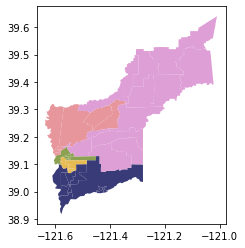

<Figure size 432x288 with 0 Axes>

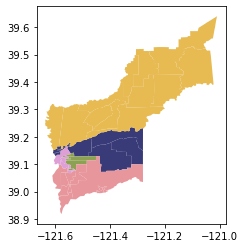

<Figure size 432x288 with 0 Axes>

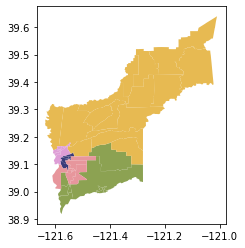

<Figure size 432x288 with 0 Axes>

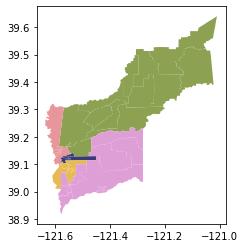

<Figure size 432x288 with 0 Axes>

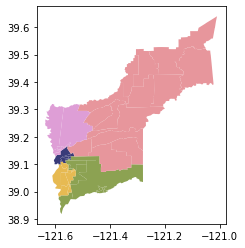

<Figure size 432x288 with 0 Axes>

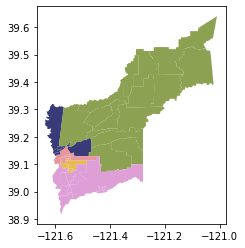

<Figure size 432x288 with 0 Axes>

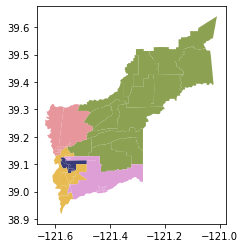

<Figure size 432x288 with 0 Axes>

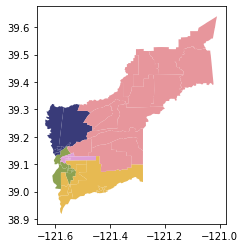

<Figure size 432x288 with 0 Axes>

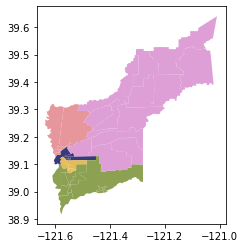

<Figure size 432x288 with 0 Axes>

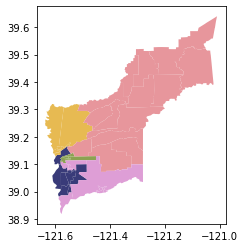

<Figure size 432x288 with 0 Axes>

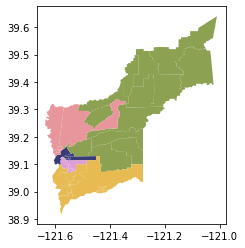

<Figure size 432x288 with 0 Axes>

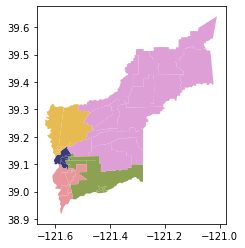

<Figure size 432x288 with 0 Axes>

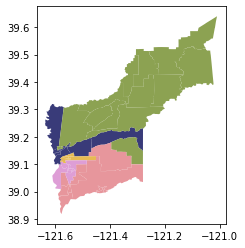

<Figure size 432x288 with 0 Axes>

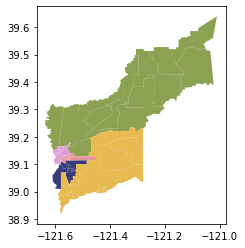

<Figure size 432x288 with 0 Axes>

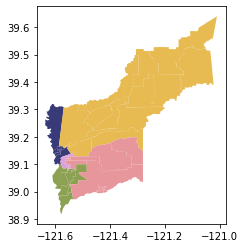

<Figure size 432x288 with 0 Axes>

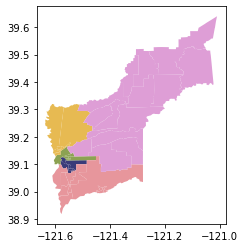

<Figure size 432x288 with 0 Axes>

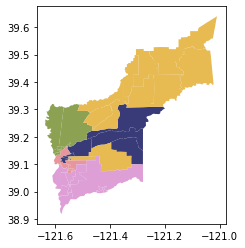

<Figure size 432x288 with 0 Axes>

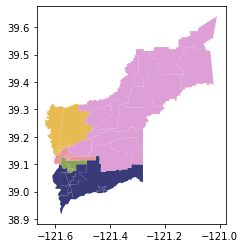

<Figure size 432x288 with 0 Axes>

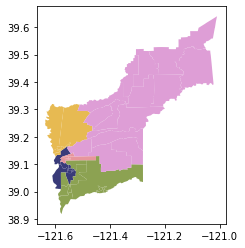

<Figure size 432x288 with 0 Axes>

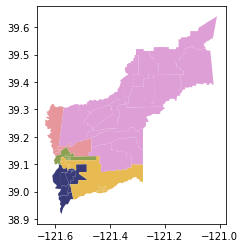

<Figure size 432x288 with 0 Axes>

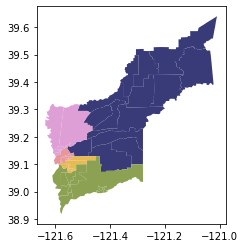

<Figure size 432x288 with 0 Axes>

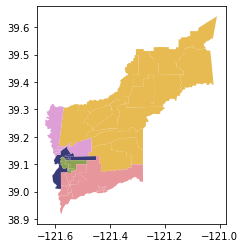

<Figure size 432x288 with 0 Axes>

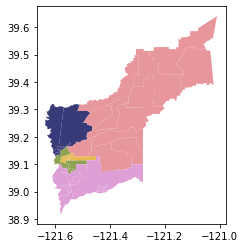

<Figure size 432x288 with 0 Axes>

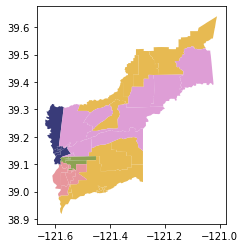

<Figure size 432x288 with 0 Axes>

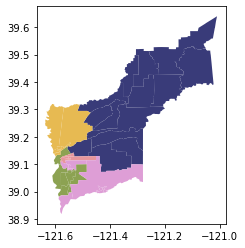

<Figure size 432x288 with 0 Axes>

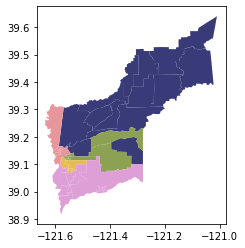

<Figure size 432x288 with 0 Axes>

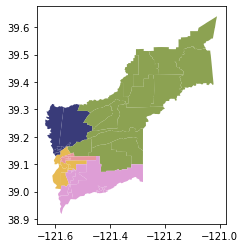

<Figure size 432x288 with 0 Axes>

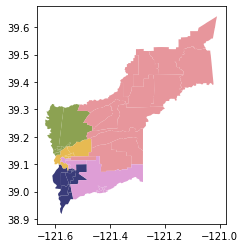

<Figure size 432x288 with 0 Axes>

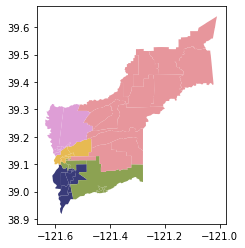

<Figure size 432x288 with 0 Axes>

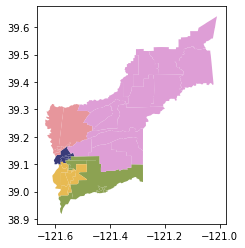

<Figure size 432x288 with 0 Axes>

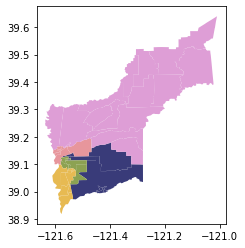

<Figure size 432x288 with 0 Axes>

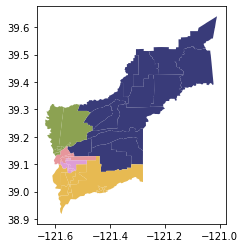

<Figure size 432x288 with 0 Axes>

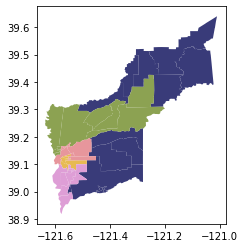

<Figure size 432x288 with 0 Axes>

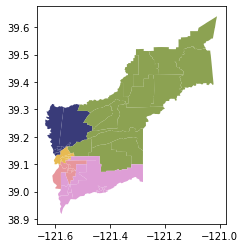

<Figure size 432x288 with 0 Axes>

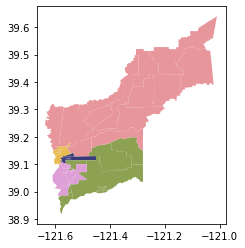

<Figure size 432x288 with 0 Axes>

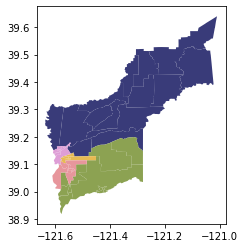

<Figure size 432x288 with 0 Axes>

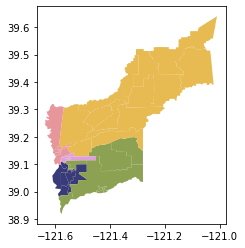

<Figure size 432x288 with 0 Axes>

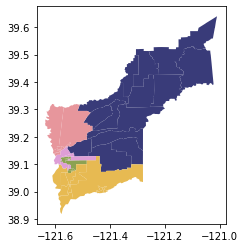

<Figure size 432x288 with 0 Axes>

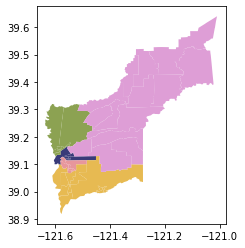

<Figure size 432x288 with 0 Axes>

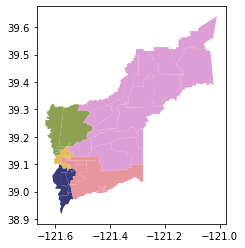

<Figure size 432x288 with 0 Axes>

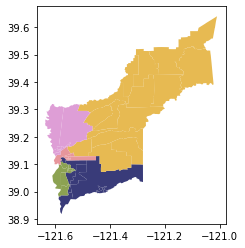

<Figure size 432x288 with 0 Axes>

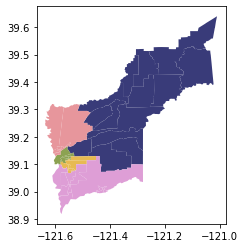

<Figure size 432x288 with 0 Axes>

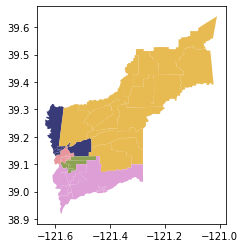

<Figure size 432x288 with 0 Axes>

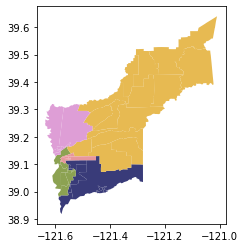

<Figure size 432x288 with 0 Axes>

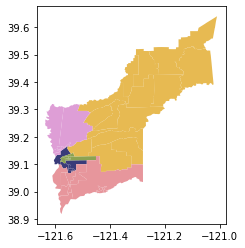

<Figure size 432x288 with 0 Axes>

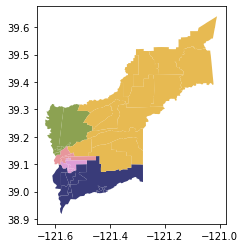

<Figure size 432x288 with 0 Axes>

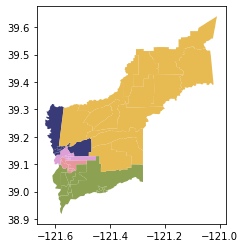

<Figure size 432x288 with 0 Axes>

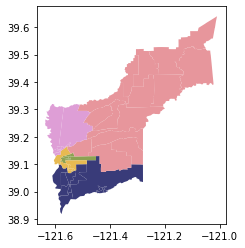

<Figure size 432x288 with 0 Axes>

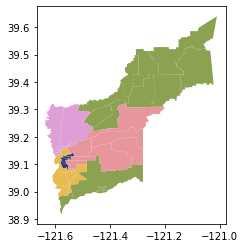

<Figure size 432x288 with 0 Axes>

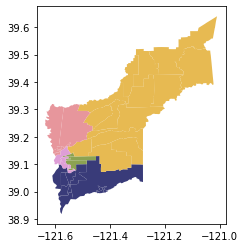

<Figure size 432x288 with 0 Axes>

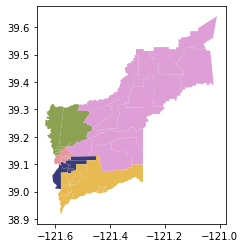

<Figure size 432x288 with 0 Axes>

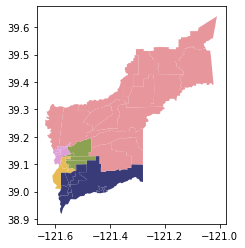

<Figure size 432x288 with 0 Axes>

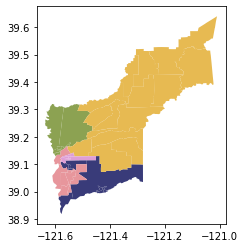

<Figure size 432x288 with 0 Axes>

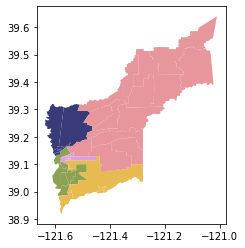

<Figure size 432x288 with 0 Axes>

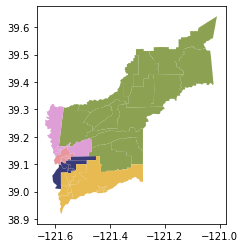

In [18]:
cuts = []

BVAPs = []
ASIANVAPs = []
HVAPs = []
WVAPs = []
VAP_ = []
population = []
clint2016 = []
trump2016 = []
totvotes = []
paths = []
dem_seats_pres = []
dem_seats_ussn = []
dem_seats_cg = []
pgini_using_pres_voting = []
pgini_using_ussn_voting = []
pgini_using_cong_voting = []

efficiency_gaps = []
efficiency_gaps_ussn = []
efficiency_gaps_cong = []
mean_medians = []
mean_medians_ussn = []
mean_medians_cong = []
t = 0

for part in MC:

    population.append(part["population"])
    totvotes.append(part["TOTVOTES"])
    cuts.append(len(part["cut_edges"]))
    BVAPs.append(sorted(part["BVAP"].percents("BVAP")))
    ASIANVAPs.append(sorted(part["ASIANVAP"].percents("ASIANVAP")))
    HVAPs.append(sorted(part["HVAP"].percents("HVAP")))
    VAP_.append(part["VAP"])
    WVAPs.append(sorted(part["WVAP"].percents("WVAP")))
    clint2016.append(sorted(part["2016_pres"].percents("PRSDEM01")))
    trump2016.append(sorted(part["2016_pres"].percents("PRSREP01")))
    dem_seats_pres.append(part["2016_pres"].wins("PRSDEM01"))
    dem_seats_ussn.append(part["2016_ussn"].wins("USSDEM01"))
    dem_seats_cg.append(part["2016_cong"].wins("CNGDEM01"))
    pgini_using_pres_voting.append(partisan_gini(part["2016_pres"]))
    pgini_using_ussn_voting.append(partisan_gini(part["2016_ussn"]))
    pgini_using_cong_voting.append(partisan_gini(part["2016_cong"]))
    efficiency_gaps_ussn.append(efficiency_gap(part["2016_ussn"]))
    efficiency_gaps_cong.append(efficiency_gap(part["2016_cong"]))
    mean_medians.append(mean_median(part["2016_pres"]))
    mean_medians_ussn.append(mean_median(part["2016_ussn"]))
    mean_medians_cong.append(mean_median(part["2016_cong"]))
    
    t+=1

    if t%100 ==0:
        print("chain",part,"step",t)
        part.to_json('part_CA'+str(t)+'.json', save_assignment_as = 'assign')
        plt.figure()
        part.plot(data,  cmap = 'tab20b')
        plt.plot()
        plt.savefig('./CA_plan_'+str(t)+'.png')
        path = './CA_plan_'+str(t)+'.png'
        paths += path
print(f"finished chain {part}")


In [19]:

bvap_results = pandas.DataFrame.from_records(
    BVAPs,
    columns=[f"bvap_{j}" for j in range(num_districts)]
)
hvap_results = pandas.DataFrame.from_records(
    HVAPs,
    columns=[f"hvap_{j}" for j in range(num_districts)]
)
asianvap_results = pandas.DataFrame.from_records(
    ASIANVAPs,
    columns=[f"asianvap_{j}" for j in range(num_districts)]
)



In [20]:
asianvap_results.to_csv('asianvap_results.csv')
bvap_results.to_csv('bvap_results.csv')
hvap_results.to_csv('hvap_results.csv')

In [21]:
np.array(cuts).mean()

36.2618

In [22]:
stats = pandas.DataFrame({
    "2016_pres_d_wins": dem_seats_pres,
    "2016_ussn_harris_wins": dem_seats_ussn,
    "2016_cg_d_wins": dem_seats_cg,
    "pgini_using_pres_voting": pgini_using_pres_voting,
    "pgini_using_ussn_voting": pgini_using_ussn_voting,
    "pgini_using_cong_voting": pgini_using_cong_voting,
    "cut_edges": cuts,
    #"efficiency_gap":efficiency_gaps,
    "efficiency_gaps_ussn": efficiency_gaps_ussn,
    "efficiency_gaps_cong": efficiency_gaps_cong,
    "mean_median": mean_medians,
    "mean_medians_ussn": mean_medians_ussn,
    "mean_medians_cong": mean_medians_cong,
    "Clinton" : clint2016,
    "Trump": trump2016,
    "BVAP": BVAPs,
    "ASIANVAPs": ASIANVAPs,
    "HVAPs": HVAPs,
    "WVAPs": WVAPs
})


In [23]:
stats.to_csv(county_name + '_stats.csv')

In [24]:
county_stats = gpd.read_file(county_name + '_stats.csv') 

In [25]:
county_stats

,field_1,2016_pres_d_wins,2016_ussn_harris_wins,2016_cg_d_wins,pgini_using_pres_voting,pgini_using_ussn_voting,pgini_using_cong_voting,cut_edges,efficiency_gaps_ussn,efficiency_gaps_cong,mean_median,mean_medians_ussn,mean_medians_cong,Clinton,Trump,BVAP,ASIANVAPs,HVAPs,WVAPs,geometry
0,0,0,5,1,0.0157050806276538,0.0061952342882328985,0.014767447117722331,41,0.3757589386102991,-0.24413990402362495,-0.004092567825652371,0.0015984062051265235,-0.007303324728559102,"[0.2924437608152278, 0.31539059463661095, 0.35...","[0.4864941711686096, 0.543552036199095, 0.5702...","[0.01853159195199435, 0.019809020723283218, 0....","[0.034606997250402956, 0.039181080127073775, 0...","[0.1244264031062478, 0.16047867444001226, 0.17...","[0.5080385852090032, 0.5602397399431126, 0.670...",None
1,1,0,5,1,0.02308334145528281,0.009778763914979293,0.018963621310900302,38,0.3757589386102991,-0.24413990402362495,-0.01525520965853927,-0.004255527237024381,0.006861019640868549,"[0.3084601538209786, 0.31539059463661095, 0.34...","[0.4864941711686096, 0.543552036199095, 0.5906...","[0.010939510939510939, 0.019809020723283218, 0...","[0.03033645890788748, 0.04354149622761567, 0.0...","[0.08788380216951645, 0.16047867444001226, 0.2...","[0.5080385852090032, 0.5602397399431126, 0.653...",None
2,2,0,5,1,0.021687520036374953,0.007212183726862742,0.025540668853153113,37,0.3757589386102991,-0.24413990402362495,-0.0008668217325636385,0.0014981954073679526,0.03187912675266763,"[0.30118289353958144, 0.31539059463661095, 0.3...","[0.4864941711686096, 0.543552036199095, 0.5649...","[0.011972009105471713, 0.019809020723283218, 0...","[0.022004889975550123, 0.050995530272247055, 0...","[0.10901273079841498, 0.16047867444001226, 0.1...","[0.5080385852090032, 0.5602397399431126, 0.650...",None
3,3,0,5,2,0.020751405577804062,0.0067397660856503006,0.02470831362843646,38,0.3757589386102991,-0.24413990402362495,-0.0003987645032781928,0.0012619865867616875,0.03229530436502592,"[0.30118289353958144, 0.3118322918766378, 0.35...","[0.4864941711686096, 0.5442085460897608, 0.564...","[0.011972009105471713, 0.022035256410256412, 0...","[0.022004889975550123, 0.054701537232980636, 0...","[0.10901273079841498, 0.17080004150669295, 0.1...","[0.5080385852090032, 0.5636017628205128, 0.650...",None
4,4,0,5,2,0.020751405577804062,0.0067397660856503006,0.02470831362843646,38,0.3757589386102991,-0.24413990402362495,-0.0003987645032781928,0.0012619865867616875,0.03229530436502592,"[0.30118289353958144, 0.3118322918766378, 0.35...","[0.4864941711686096, 0.5442085460897608, 0.564...","[0.011972009105471713, 0.022035256410256412, 0...","[0.022004889975550123, 0.054701537232980636, 0...","[0.10901273079841498, 0.17080004150669295, 0.1...","[0.5080385852090032, 0.5636017628205128, 0.650...",None
5,5,0,5,1,0.021753431436787353,0.0061721146732182765,0.019325725392680106,42,0.3757589386102991,-0.24413990402362495,0.0016811854661267223,-0.0015200224911893212,0.002707327677466509,"[0.30118289353958144, 0.3226837060702875, 0.35...","[0.4864941711686096, 0.5648837209302325, 0.564...","[0.011972009105471713, 0.03098819016856768, 0....","[0.022004889975550123, 0.05339658827091955, 0....","[0.10901273079841498, 0.1997404671591136, 0.21...","[0.5080385852090032, 0.5876055178093473, 0.641...",None
6,6,0,5,1,0.021687520036374953,0.007212183726862742,0.025540668853153113,37,0.3757589386102991,-0.24413990402362495,-0.0008668217325636385,0.0014981954073679526,0.03187912675266763,"[0.30118289353958144, 0.31539059463661095, 0.3...","[0.4864941711686096, 0.543552036199095, 0.5649...","[0.011972009105471713, 0.019809020723283218, 0...","[0.022004889975550123, 0.050995530272247055, 0...","[0.10901273079841498, 0.16047867444001226, 0.1...","[0.5080385852090032, 0.5602397399431126, 0.650...",None
7,7,0,5,1,0.021687520036374953,0.007212183726862742,0.025540668853153113,37,0.3757589386102991,-0.24413990402362495,-0.0008668217325636385,0.0014981954073679526,0.03187912675266763,"[0.30118289353958144, 0.31539059463661095, 0.3.

### Metrics

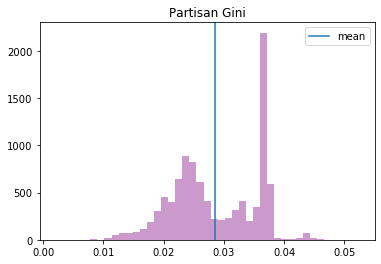

In [26]:
colors = ['hotpink','goldenrod','green','purple']
labels= ['precinct']
plt.figure()
for i in range(1):
    sns.distplot(pgini_using_pres_voting,kde=False, color=colors[3])
plt.axvline(np.array(pgini_using_pres_voting).mean(), label = 'mean')
#plt.axvline(partisan_gini(current_partition["2016_pres"]), label = 'current plan', color = 'red')
plt.legend()
plt.title("Partisan Gini")
plt.savefig('partisangini.png')
plt.show()


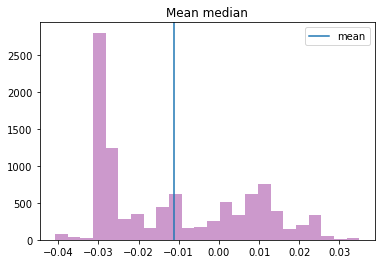

In [27]:
colors = ['hotpink','goldenrod','green','purple']
labels= ['precinct']
plt.figure()
for i in range(1):
    sns.distplot(mean_medians,kde=False, color=colors[3])
plt.axvline(np.array(mean_medians).mean(), label = 'mean')
#plt.axvline(mean_median(current_partition["2016_pres"]), label = 'current plan', color = 'red')
plt.legend()
plt.title("Mean median")
plt.savefig('meanmedian.png')
plt.show()


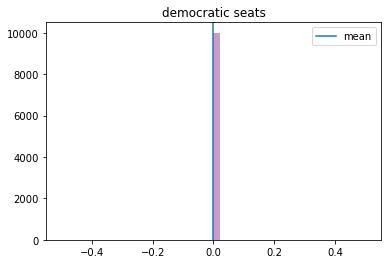

In [28]:
colors = ['hotpink','goldenrod','green','purple']
labels= ['precinct']
plt.figure()
for i in range(1):
    sns.distplot(dem_seats_pres,kde=False, color=colors[3])
plt.axvline(np.array(dem_seats_pres).mean(), label = 'mean')
#plt.axvline(current_partition["2016_pres"].wins("pres_clint"), label = 'current plan', color = 'red')
plt.legend()
plt.title("democratic seats")
plt.savefig('seats_prs.png')
plt.show()

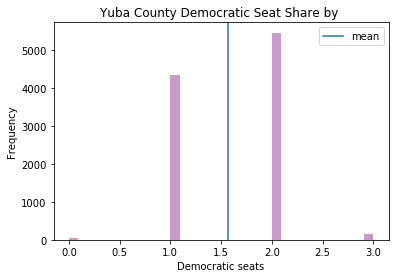

In [29]:
colors = ['hotpink','goldenrod','green','purple']
labels= ['precinct']
plt.figure()
for i in range(1):
    sns.distplot(dem_seats_cg,kde=False, color=colors[3])
plt.axvline(np.array(dem_seats_cg).mean(), label = 'mean')
#plt.axvline(current_partition["2016_pres"].wins("pres_clint"), label = 'current plan', color = 'red')
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Democratic seats")
plt.title(county_name + " County Democratic Seat Share by ")
plt.savefig('seats_cg.png')
plt.show()


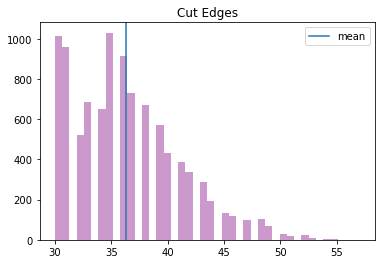

In [30]:
colors = ['hotpink','goldenrod','green','purple']
labels= ['precinct']
plt.figure()
for i in range(1):
    sns.distplot(cuts,kde=False, color=colors[3])
plt.axvline(np.array(cuts).mean(), label = 'mean')
#plt.axvline(5201, label = 'current plan', color = 'red')
plt.legend()
plt.title("Cut Edges")
plt.savefig('cutedges.png')
plt.show()


/anaconda3/envs/vrdi/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'manage_xticks' parameter of boxplot() has been renamed 'manage_ticks' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


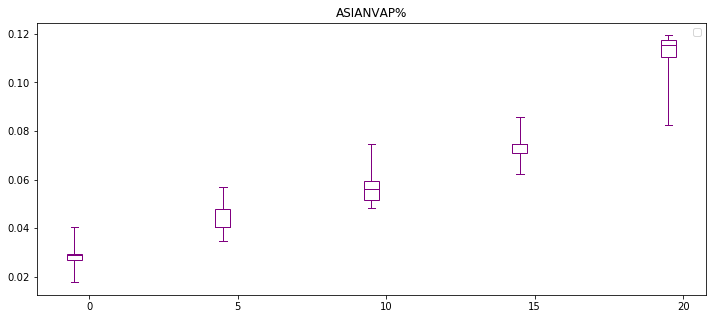

In [31]:
fig, ax = plt.subplots(figsize = (12,5))
draw_plot(np.array(ASIANVAPs),-1.5,colors[3],'w')
#plt.plot(5*np.arange(np.array(ASIANVAPs).shape[1])+1-1.5,curr_asian,  'o', label = 'Current plan')
plt.title("ASIANVAP%")
for i in range(1):
    plt.plot([],[],color=colors[3])
plt.legend()
plt.savefig('asianvap.png')
plt.show()


/anaconda3/envs/vrdi/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'manage_xticks' parameter of boxplot() has been renamed 'manage_ticks' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


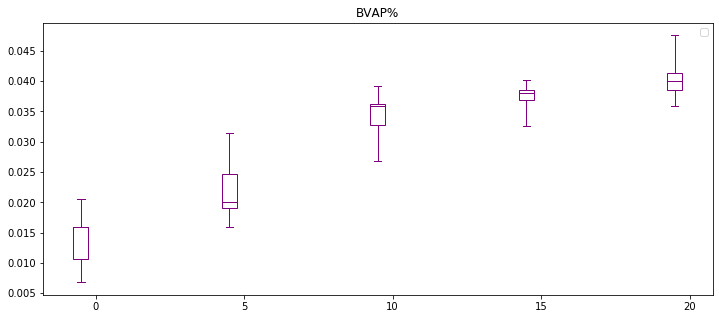

In [32]:
#curr_b = sorted(current_partition["BVAP"].percents("BVAP"))
fig, ax = plt.subplots(figsize = (12,5))
draw_plot(np.array(BVAPs),-1.5,colors[3],'w')
#plt.plot(5*np.arange(np.array(BVAPs).shape[1])+1-1.5,curr_b,  'o', label = 'Current plan')
plt.title("BVAP%")
for i in range(1):
    plt.plot([],[],color=colors[3])
plt.legend()
plt.savefig('bvap.png')


/anaconda3/envs/vrdi/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'manage_xticks' parameter of boxplot() has been renamed 'manage_ticks' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


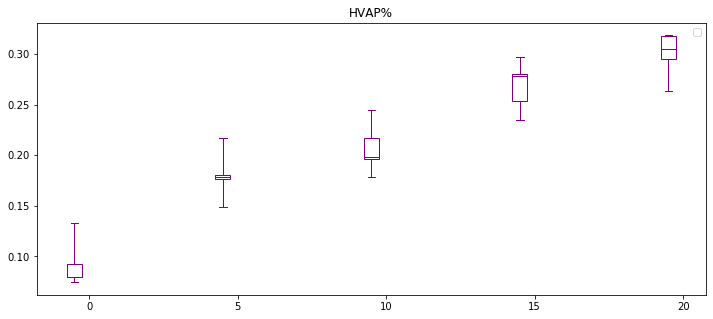

In [33]:
#curr_b = sorted(current_partition["HVAP"].percents("HVAP"))
fig, ax = plt.subplots(figsize = (12,5))
draw_plot(np.array(HVAPs),-1.5,colors[3],'w')
#plt.plot(5*np.arange(np.array(HVAPs).shape[1])+1-1.5,curr_b,  'o', label = 'Current plan')
plt.title("HVAP%")
for i in range(1):
    plt.plot([],[],color=colors[3])
plt.legend()
plt.savefig('hvap.png')
plt.show()
